In [1]:
import pandas as pd

df = pd.read_csv('group_results/unparied_ttest/group_stats.csv', header=[0,1], index_col=0)


In [2]:
conc_diff_df = df.filter(regex='conc_', axis=0).filter(axis=1, regex=r'\>')
conc_diff_df.index = conc_diff_df.index.str.replace('conc_', '')
conc_diff_df.index = conc_diff_df.index.str.replace('_c_', '_')

conc_diff_df_MM = conc_diff_df.filter(like='MM', axis=0)

conc_diff_df_biexp = conc_diff_df.loc[~conc_diff_df.index.str.contains('MM'), :]
conc_diff_df_biexp.index = pd.MultiIndex.from_tuples(conc_diff_df_biexp.index.str.split('_', n=1).tolist())


Look at fitted amplitudes

In [114]:

original_metabs_analysed = ['Lac', 'GABA', 'Gln', 'Glu', 'Ins', 'NAA', 'Tau', 'PCho+GPC']

idx = pd.IndexSlice
df_amp_styled= conc_diff_df_biexp.loc[idx[original_metabs_analysed, 'amp'], :]\
.droplevel(axis=0, level=1)\
.style\
.format(formatter={('z', 'WT>CNTF'):    "{:+05.2f}", ('z', 'CNTF>WT'):    "{:+05.2f}",
                   ('p', 'WT>CNTF'):    "{:05.3f}", ('p', 'CNTF>WT'):    "{:05.3f}"})\
.highlight_between(subset=['p'],left=0, right=0.05, props='font-weight:bold;color:#e83e8c')

import dataframe_image as dfi
df_amp_styled.export_png('../../publication/figures/st3_invivo_dwmrs_amp.png')
df_amp_styled

/Users/wclarke/miniconda3/envs/fsl_mrs/lib/python3.8/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
objc[47121]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa5a5f13f0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/109.0.5414.119/Libraries/libGLESv2.dylib (0x10e8fb880). One of the two will be used. Which one is undefined.
[0301/112016.325186:INFO:headless_shell.cc(223)] 161695 bytes written to file /var/folders/nn/v2nq0rss0yz3zzf069f84hxw0000gt/T/tmptasqb0wo/temp.png


In [4]:

original_metabs_analysed = ['NAA', 'Cr+PCr', 'PCho+GPC', 'Glu', 'Ins', 'Tau', 'Lac']

idx = pd.IndexSlice
conc_diff_df_biexp.loc[idx[original_metabs_analysed, ['adc_slow', 'adc_fast', 'frac_slow']], :]\
.style\
.format(formatter={('z', 'WT>CNTF'):    "{:+05.2f}", ('z', 'CNTF>WT'):    "{:+05.2f}",
                   ('p', 'WT>CNTF'):    "{:05.3f}", ('p', 'CNTF>WT'):    "{:05.3f}"})\
.highlight_between(subset=['p'],left=0, right=0.05, props='font-weight:bold;color:#e83e8c')


In [5]:
conc_abs_df = df.filter(regex='conc_', axis=0).loc[:, idx[:, ['WT', 'CNTF']]]
conc_abs_df.index = conc_abs_df.index.str.replace('conc_', '')
conc_abs_df.index = conc_abs_df.index.str.replace('_c_', '_')
conc_abs_df = conc_abs_df.swaplevel(axis=1)

conc_abs_df_biexp = conc_abs_df.loc[~conc_abs_df.index.str.contains('MM'), :]
conc_abs_df_biexp.index = pd.MultiIndex.from_tuples(conc_abs_df_biexp.index.str.split('_', n=1).tolist())


In [116]:
from dmrs_model_biexp_mm_lin import model_biexp
import numpy as np

original_metabs_plotted = ['NAA', 'Cr+PCr', 'PCho+GPC', 'Glu', 'Tau', 'Ins', 'Lac']
bvals = np.loadtxt('bvals')
idx = pd.IndexSlice
vals = conc_abs_df_biexp.loc[idx[:, ['adc_slow', 'adc_fast', 'frac_slow']], :]

def calculate_trace_error(met, group):
    c_vals = vals.loc[met, (group, 'COPE')].to_numpy()
    c_vals = np.insert(c_vals, 0, 1.0)
    c_var = vals.loc[met, (group, 'VARCOPE')].to_numpy()
    c_var = np.insert(c_var, 0, 0.0)
    c_var = np.diag(c_var)
    bs_vals = np.random.default_rng().multivariate_normal(c_vals, c_var, 15000)
    traces = np.stack([model_biexp(x, bvals) for x in bs_vals])
    traces = np.log(traces)
    return traces.mean(axis=0), traces.std(axis=0)


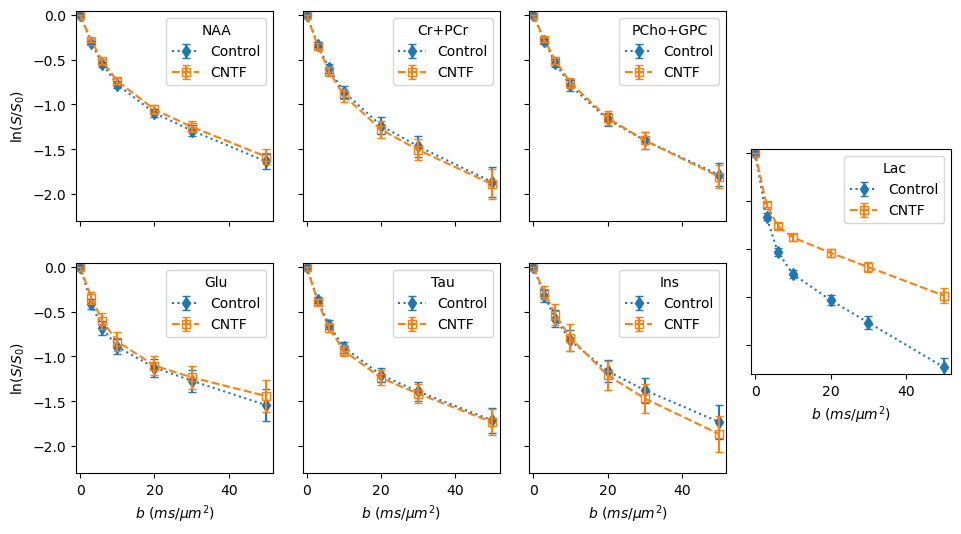

In [117]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 6))

gs1 = GridSpec(2, 3, left=0.05, right=0.70, wspace=0.15)
gs2 = GridSpec(1,1, left=0.725, right=0.925, wspace=0.05, bottom=0.275, top=0.65)

all_gs = [gs1[0, 0], gs1[0, 1], gs1[0, 2], gs1[1, 0], gs1[1, 1], gs1[1, 2], gs2[0]]
axes = [fig.add_subplot(gs) for gs in all_gs]
for ax, metab in zip(axes, original_metabs_plotted): 
    trace_wt, err_wt = calculate_trace_error(metab, 'WT')
    ax.errorbar(bvals, trace_wt, yerr=err_wt, label='Control', marker='d', linestyle=':', barsabove=True, capsize=3)

    trace_cntf, err_cntf = calculate_trace_error(metab, 'CNTF')
    ax.errorbar(bvals, trace_cntf, yerr=err_cntf, label='CNTF', marker='s', linestyle='--', barsabove=True, markerfacecolor='none', capsize=3)

    ax.legend(title=metab)
    ax.set_xlim([-1, 52])
    ax.set_ylim([-2.3, 0.04])
axes[0].set_ylabel('$\ln(S/S_0)$')
axes[3].set_ylabel('$\ln(S/S_0)$')
for idx in [1,2,4,5, 6]:
    axes[idx].set_yticklabels(labels=[])
for ax in axes[:3]:
    ax.set_xticklabels(labels=[])
for ax in axes[3:]:
    ax.set_xlabel('$b$ ($ms/\mu m^2$)')

plt.savefig('../../publication/figures/fig10_invivo_dwmrs.png', dpi=400, bbox_inches='tight', transparent=True)
